In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/train_images_list.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/all_qa_pairs.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/test_images_list.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data.csv
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/answer_space.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1268.png
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image745.png
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image883.png
/kaggle/input/visual-question-answering-computer-vision

In [6]:
train_path = r"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv"
eval_path = r"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv"
image_path = r"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images"

In [7]:
pre_dataset = pd.DataFrame(pd.read_csv(train_path))
pre_dataset

question        answer  \
0                     what is the object on the shelves           cup   
1                              how man chairs are there             6   
2           what is hanged to the right side of the bed       curtain   
3                      how many picture are on the wall             2   
4       what is the object on the floor behind the rack  room_divider   
...                                                 ...           ...   
9969                  what is to the right of the table       cabinet   
9970                     what is the colour of the lamp         black   
9971                            what is behind the lamp       curtain   
9972  what is the object close to the middle counter...         stove   
9973                            what is above the stove     microwave   

       image_id  
0      image100  
1      image888  
2     image1174  
3      image942  
4     image1220  
...         ...  
9969  image1349  
9970   image956  
9971  image1009  
9972   image908  
9973   image126  

[9974 rows x 3 columns]

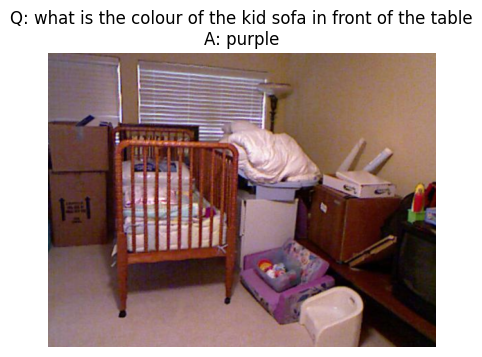

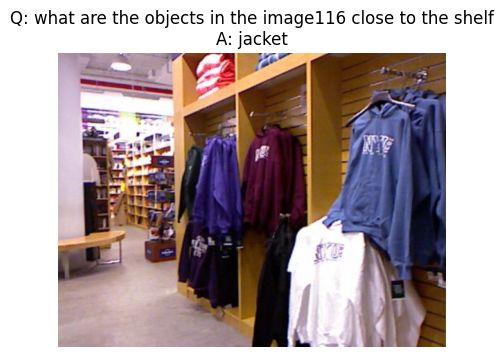

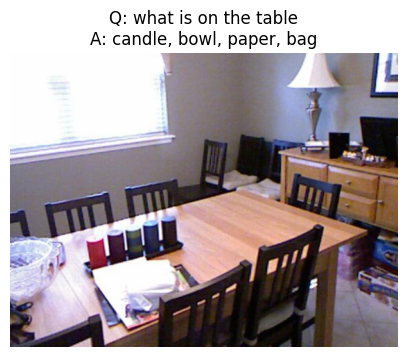

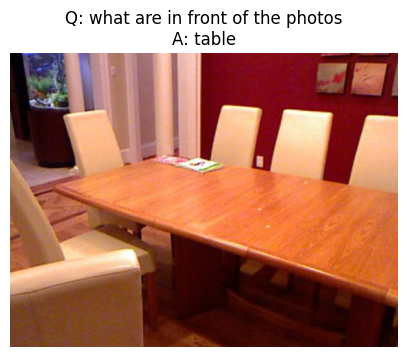

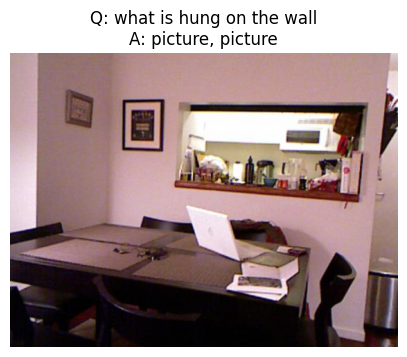

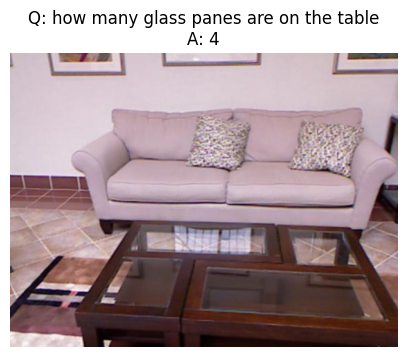

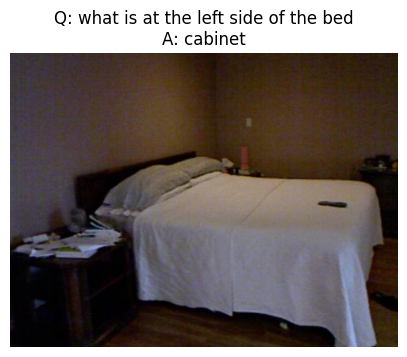

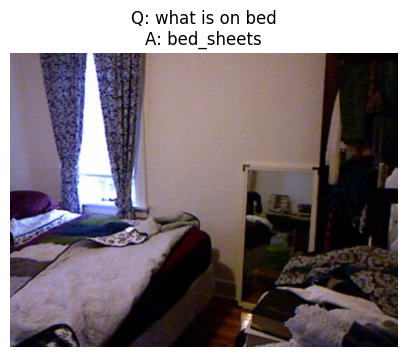

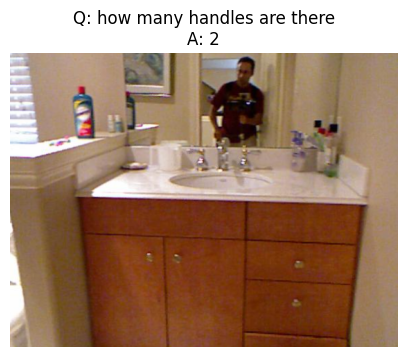

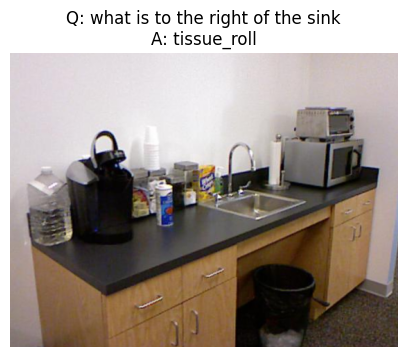

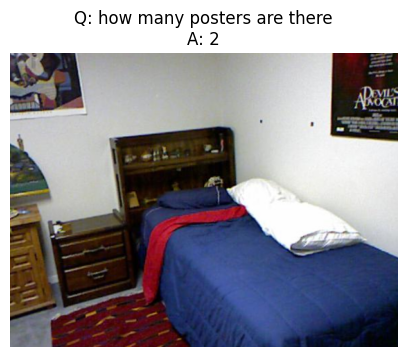

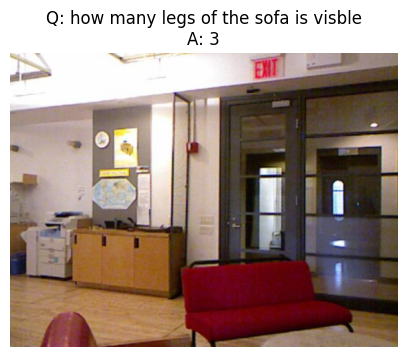

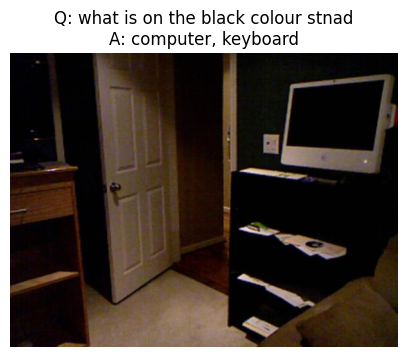

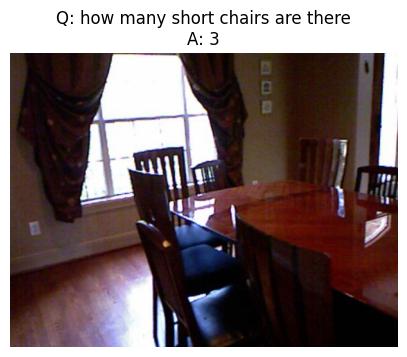

In [8]:

import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image

# Đọc file train
sample_df = pd.read_csv(train_path)

# Thêm phần mở rộng .png vào cột image_id
sample_df['image_id'] = sample_df['image_id'].astype(str) + '.png'

# Lấy ngẫu nhiên 10–15 ảnh
samples = sample_df.sample(n=random.randint(10, 15)).reset_index(drop=True)

# Hiển thị từng ảnh kèm câu hỏi & câu trả lời
for i, row in samples.iterrows():
    image = os.path.join(image_path, row['image_id'])
    if not os.path.exists(image):
        print(f"⚠️ Missing image: {row['image_id']}")
        continue

    question = row['question']
    answer = row['answer']

    img = Image.open(image)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Q: {question}\nA: {answer}")
    plt.axis("off")
    plt.show()

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import AdamW

transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Thêm 1 vài bước xử lý ảnh để đa dạng hóa dữ liệu - Data Augmentation
    transforms.RandomRotation(30),  # Xoay ảnh ngẫu nhiên trong khoảng ±30 độ
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh độ sáng, độ tương phản
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

In [11]:
#Tokenizer sử dụng spacy
def spacy_tokenizer(text):
    tokens = []
    for token in nlp(text):
        if not token.is_punct and not token.is_space: # Nếu không phải là dấu câu hoặc là khoảng trống thì thêm vào tokens
            tokens.append(token.text.lower())
    return tokens # Trả về mảng có chứa các chữ trong câu

In [12]:
#Xây dựng vocab cho bài toán
def build_vocab(texts, min_freq = 1):
    """
    texts: danh sách các câu hỏi hoặc trả lời được đưa vào
    min_freq: Tần suất tối thiểu 1 chữ xuất hiện để đưa vào vocab
    """
    counter = Counter()
    for text in texts:
        counter.update(spacy_tokenizer(text)) #Counter để đếm xem 1 chữ xuất hiện bao nhiêu lần
    # print(counter)

    vocab = {}
    vocab["<unk>"] = 0  # Token unknown
    vocab["<pad>"] = 1  # Token padding
    vocab["<sos>"] = 2  # Start of sentence
    vocab["<eos>"] = 3  # End of sentence

    index = 4 #Bắt đầu từ 2 do 0 với 1 dành cho <UNK>, <PAD>
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    # print(vocab)
    return vocab

In [13]:
print(sample_df.head())
print(sample_df.columns)

                                          question        answer  \
0                what is the object on the shelves           cup   
1                         how man chairs are there             6   
2      what is hanged to the right side of the bed       curtain   
3                 how many picture are on the wall             2   
4  what is the object on the floor behind the rack  room_divider   

        image_id  
0   image100.png  
1   image888.png  
2  image1174.png  
3   image942.png  
4  image1220.png  
Index(['question', 'answer', 'image_id'], dtype='object')


In [14]:
dataframe = pd.DataFrame(pd.read_csv(train_path))
dataframe

question        answer  \
0                     what is the object on the shelves           cup   
1                              how man chairs are there             6   
2           what is hanged to the right side of the bed       curtain   
3                      how many picture are on the wall             2   
4       what is the object on the floor behind the rack  room_divider   
...                                                 ...           ...   
9969                  what is to the right of the table       cabinet   
9970                     what is the colour of the lamp         black   
9971                            what is behind the lamp       curtain   
9972  what is the object close to the middle counter...         stove   
9973                            what is above the stove     microwave   

       image_id  
0      image100  
1      image888  
2     image1174  
3      image942  
4     image1220  
...         ...  
9969  image1349  
9970   image956  
9971  image1009  
9972   image908  
9973   image126  

[9974 rows x 3 columns]

In [15]:
eval_dataframe = pd.DataFrame(pd.read_csv(eval_path))
eval_dataframe

question                      answer  \
0     what is the colour of the bag on the chair                        pink   
1                    what is at the right bottom                       table   
2                     what are found on the rack                         toy   
3                        what is left of printer                      mirror   
4               what is the colour of television                       black   
...                                          ...                         ...   
2489                 what is beneath the monitor                       paper   
2490                  what is the largest object                         bed   
2491        what is on the right side of the tap  bottle_of_hand_wash_liquid   
2492         how many lights are above the table                           3   
2493                        what is on the table             decorative_item   

       image_id  
0      image399  
1     image1341  
2     image1320  
3      image529  
4      image201  
...         ...  
2489   image528  
2490  image1077  
2491   image695  
2492   image875  
2493  image1377  

[2494 rows x 3 columns]

In [16]:
vocab_questions = build_vocab(dataframe['question'])
vocab_answers = build_vocab(dataframe['answer'])

In [17]:
# Lấy kích thước của các vocab
questions_vocab_size = len(vocab_questions)
answers_vocab_size = len(vocab_answers)

In [18]:
idx2word_answers = {idx: word for word, idx in vocab_answers.items()} #Đây sẽ là phần đối chiếu từ 1 indice sang 1 từ

In [19]:
# Kiểm tra một số từ trong vocab
print("Sample vocab from questions:")
for word, index in list(idx2word_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

print("\nSample vocab from answers:")
for word, index in list(idx2word_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

Sample vocab from questions:
0: <unk>
1: <pad>
2: <sos>
3: <eos>
4: cup
5: 6
6: curtain
7: 2
8: room_divider
9: garbage_bin

Sample vocab from answers:
0: <unk>
1: <pad>
2: <sos>
3: <eos>
4: cup
5: 6
6: curtain
7: 2
8: room_divider
9: garbage_bin


In [20]:
#Hàm sẽ biến đổi 1 tensor chứa các indice chuyển sang thành 1 câu dựa trên idx2word_answers
def decode_answer(tensor, vocab_dict):
    return " ".join([vocab_dict[idx] for idx in tensor if idx not in {0, 1}])
def get_max_len(texts):
    max_len = 0
    for text in texts:
        tokens = spacy_tokenizer(text)
        if len(tokens) > max_len:
            max_len = len(tokens)
    return max_len

In [21]:
# len_max_question = get_max_len(dataframe['question'])
# len_max_answer = get_max_len(dataframe['response'])

len_max_question = 24
len_max_answer = 7

In [22]:
#Biến đổi từ 1 câu sang 1 tensor
def text_to_tensor(text, vocab, max_len):
    """
    text: câu hỏi
    vocab: từ điển các từ đã xuất hiện trong tập câu hỏi và câu trả lời
    max_len: chiều dài
    """
    tokens = spacy_tokenizer(text)
    tokens = ["<sos>"] + tokens + ["<eos>"]

    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    # Điều chỉnh độ dài
    if len(indices) < max_len:  # Padding
        indices += [vocab["<pad>"]] * (max_len - len(indices))
    else:  # Truncate
        indices = indices[:max_len]

    return torch.tensor(indices, dtype=torch.long)

In [23]:
class VQADataset(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.df = pd.read_csv(csv_path)
        self.df['image_id'] = self.df['image_id'] + '.png'  # Thêm phần mở rộng ảnh
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_id'])
        question = text_to_tensor(row['question'], vocab_questions, len_max_question)
        answer = text_to_tensor(row['answer'], vocab_answers, len_max_answer)

        # Kiểm tra ảnh tồn tại không
        if os.path.exists(image_path):
            img = Image.open(image_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.zeros((3, 224, 224))  # Ảnh placeholder nếu bị lỗi
            print(f"Ảnh không tồn tại: {image_path}")

        return img, question, answer

In [24]:
train_dataset = VQADataset(train_path, image_path, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers = 4)
eval_dataset = VQADataset(eval_path, image_path, transform)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, num_workers=4)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights
from torch.optim import AdamW

# ======================================================
# 1️⃣ CNN Feature Extractor
# ======================================================
class CNN_Feature_Extractor_pretrained(nn.Module):
    def __init__(self, output_dim=512, trainable=False):
        super(CNN_Feature_Extractor_pretrained, self).__init__()

        try:
            resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        except:
            resnet = models.resnet50(pretrained=True)

        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

        if not trainable:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(2048, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# ======================================================
# 2️⃣ Question Encoder
# ======================================================
class Question_Encoder(nn.Module):
    def __init__(self, questions_vocab_size, embedding_dim=256, hidden_dim=512):
        super(Question_Encoder, self).__init__()
        self.embedding = nn.Embedding(questions_vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=0.2, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return hidden[-1]

# ======================================================
# 3️⃣ Attention
# ======================================================
class Attention(nn.Module):
    def __init__(self, hidden_dim=512):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, combined_feat):
        if hidden.dim() > 2:
            hidden = hidden.squeeze(0)
        if hidden.dim() == 1:
            hidden = hidden.unsqueeze(0)

        concat = torch.cat((hidden, combined_feat), dim=1)
        energy = torch.tanh(self.attn(concat))
        gate = torch.sigmoid(self.v(energy))
        context = gate * combined_feat
        return context, gate

# ======================================================
# 4️⃣ Answer Decoder
# ======================================================
class Answer_Decoder(nn.Module):
    def __init__(self, answer_vocab_size, embedding_size=300, hidden_dim=512,
                 k_beam=1, max_answer_len=7, use_greedy=True):
        super(Answer_Decoder, self).__init__()
        self.embedding = nn.Embedding(answer_vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_dim * 2, hidden_dim,
                            num_layers=2, dropout=0.3, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, answer_vocab_size)

        self.k_beam = k_beam
        self.max_answer_len = max_answer_len
        self.use_greedy = use_greedy
        self.end_token = 3
        self.start_token = 2

    def forward(self, question_feat, image_feat, answer_seq=None):
        combined_feat = torch.cat((question_feat, image_feat), dim=1)
        batch_size = combined_feat.size(0)
        device = combined_feat.device

        # Training
        if answer_seq is not None:
            x = self.embedding(answer_seq)
            hidden_state = None
            outputs = []
            for i in range(x.size(1)):
                context, _ = self.attention(
                    hidden_state[0][-1] if hidden_state else question_feat, combined_feat
                )
                lstm_input = torch.cat((x[:, i, :], context), dim=1).unsqueeze(1)
                output, hidden_state = self.lstm(lstm_input, hidden_state)
                outputs.append(self.fc(output.squeeze(1)))
            return torch.stack(outputs, dim=1)

        # Inference
        else:
            results = []
            for b in range(batch_size):
                b_q_feat = question_feat[b:b+1]
                b_comb_feat = combined_feat[b:b+1]
                seq = torch.tensor([[self.start_token]], dtype=torch.long, device=device)
                hidden = None
                with torch.no_grad():
                    for _ in range(self.max_answer_len):
                        x = self.embedding(seq[:, -1])
                        context, _ = self.attention(hidden[0][-1] if hidden else b_q_feat, b_comb_feat)
                        lstm_input = torch.cat((x, context), dim=1).unsqueeze(1)
                        output, hidden = self.lstm(lstm_input, hidden)
                        logits = self.fc(output.squeeze(1))
                        probs = F.log_softmax(logits, dim=1)
                        next_token = probs.argmax(dim=1, keepdim=True) if self.use_greedy else probs.topk(self.k_beam)[1][:, 0:1]
                        seq = torch.cat([seq, next_token], dim=1)
                        if next_token[0].item() == self.end_token:
                            break
                results.append(seq)

            max_len = max(s.size(1) for s in results)
            padded = []
            for s in results:
                pad_len = max_len - s.size(1)
                if pad_len > 0:
                    pad = torch.full((1, pad_len), self.end_token, dtype=torch.long, device=device)
                    s = torch.cat([s, pad], dim=1)
                padded.append(s)
            return torch.cat(padded, dim=0)


In [26]:
# 5️⃣ VQA Model
# ======================================================
class VQA_Model(nn.Module):
    def __init__(self, questions_vocab_size, answers_vocab_size,
                 embedding_size=300, hidden_dim=512,
                 k_beam=1, max_answer_len=7, use_greedy=True, device="cuda"):
        super(VQA_Model, self).__init__()
        self.device = device
        self.image_encoder_resnet50_pretrained = CNN_Feature_Extractor_pretrained().to(device)
        self.question_encoder = Question_Encoder(questions_vocab_size).to(device)
        self.answer_decoder = Answer_Decoder(
            answer_vocab_size=answers_vocab_size,
            embedding_size=embedding_size,
            hidden_dim=hidden_dim,
            k_beam=k_beam,
            max_answer_len=max_answer_len,
            use_greedy=use_greedy
        ).to(device)

    def forward(self, image, question, answer_seq=None):
        image_feat = self.image_encoder_resnet50_pretrained(image)
        question_feat = self.question_encoder(question)
        output = self.answer_decoder(question_feat, image_feat, answer_seq)
        return output

In [27]:
# 4️⃣  Hàm chuyển tensor → text đồng bộ
# ======================================================
def tensor_to_text(tensor, idx2word):
    """
    Chuyển tensor đầu ra của mô hình thành câu trả lời dạng văn bản, loại bỏ <sos>, <eos>, <pad>.
    """
    sentences = []
    for seq in tensor:
        words = []
        for idx in seq:
            token = idx.item()
            if token in idx2word:
                word = idx2word[token]
                if word in ["<sos>", "<pad>"]:
                    continue
                if word == "<eos>":
                    break
                words.append(word)
        sentence = " ".join(words).strip()
        sentences.append(sentence)
    return sentences

In [28]:
# SETUP RANDOM SEED
# ---------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ---------------------
# F1 FUNCTIONS
# ---------------------
def sentence_f1(reference, candidate):
    ref_tokens  = reference.split()
    cand_tokens = candidate.split()
    ref_counter, cand_counter = Counter(ref_tokens), Counter(cand_tokens)
    overlap = sum(min(cand_counter[w], ref_counter.get(w,0)) for w in cand_counter)
    precision = overlap / sum(cand_counter.values()) if cand_counter else 0
    recall    = overlap / sum(ref_counter.values())  if ref_counter else 0
    return (2*precision*recall/(precision+recall)) if (precision+recall)>0 else 0

def compute_f1(ref_sentences, cand_sentences):
    f1_scores = [sentence_f1(ref, cand) for ref, cand in zip(ref_sentences, cand_sentences)]
    return sum(f1_scores)/len(f1_scores) if f1_scores else 0

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
VQA_model = VQA_Model(
    questions_vocab_size=questions_vocab_size,
    answers_vocab_size=answers_vocab_size,
    k_beam=1,
    max_answer_len=7,
    use_greedy=True
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=1)
optimizer = AdamW(VQA_model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.8MB/s]


In [35]:
import time


In [36]:
# ---------------------
# TRAINING FUNCTION
# ---------------------
def train_model(model, train_loader, eval_loader, criterion, optimizer, best_model_path,
                num_epochs=50, patience=5, device=None, scheduler=None):

    model.to(device)
    best_loss = float('inf')
    no_improve_epochs = 0

    history = {
        "train_loss": [],
        "eval_loss": [],
        "f1_score": [],
        "accuracy": []
    }

    for epoch in range(num_epochs):
        start_time = time.time()

        # === TRAIN ===
        model.train()
        total_loss = 0
        for images, questions, answers in train_loader:
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)
            optimizer.zero_grad()
            output = model(images, questions, answers[:, :-1])
            loss = criterion(output.view(-1, output.size(-1)), answers[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # === EVAL ===
        model.eval()
        eval_loss = 0
        all_preds, all_refs = [], []
        total_correct, total_tokens = 0, 0

        with torch.no_grad():
            for images, questions, answers in eval_loader:
                images, questions, answers = images.to(device), questions.to(device), answers.to(device)

                output = model(images, questions, answers[:, :-1])
                loss = criterion(output.view(-1, output.size(-1)), answers[:, 1:].reshape(-1))
                eval_loss += loss.item()

                # Token-level accuracy
                _, preds = torch.max(output, dim=-1)
                mask = (answers[:, 1:] != 1)
                correct = ((preds == answers[:, 1:]) & mask).sum().item()
                total_correct += correct
                total_tokens += mask.sum().item()

                # F1 (sentence-level)
                predicted_texts = tensor_to_text(preds, idx2word_answers)
                reference_texts = tensor_to_text(answers[:, 1:], idx2word_answers)
                all_preds.extend(predicted_texts)
                all_refs.extend(reference_texts)

        avg_eval_loss = eval_loss / len(eval_loader)
        avg_f1 = compute_f1(all_refs, all_preds)
        token_acc = total_correct / total_tokens if total_tokens > 0 else 0

        if scheduler:
            scheduler.step(avg_eval_loss)

        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | "
              f"Eval Loss: {avg_eval_loss:.4f} | F1: {avg_f1:.4f} | Token Acc: {token_acc:.4f} | "
              f"Time: {end_time - start_time:.2f}s")

        # SAVE BEST MODEL
        if avg_eval_loss < best_loss:
            best_loss = avg_eval_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), best_model_path)
            print("✅ Best model saved!")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{patience} epochs.")
            if no_improve_epochs >= patience:
                print("⏹️ Early stopping triggered.")
                break

        history["train_loss"].append(avg_train_loss)
        history["eval_loss"].append(avg_eval_loss)
        history["f1_score"].append(avg_f1)
        history["accuracy"].append(token_acc)

    return history


In [37]:
# TRAIN WRAPPER
# ---------------------
def train_vqa(train_loader, eval_loader, num_epochs=50):
    return train_model(
        model=VQA_model,
        train_loader=train_loader,
        eval_loader=eval_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        best_model_path='/kaggle/working/VQA_best.pth',
        num_epochs=num_epochs,
        patience=5,
        device=device
    )

In [39]:
VQA_model_history = train_vqa(train_loader, eval_loader, num_epochs=50)

Epoch [1/50] | Train Loss: 3.0890 | Eval Loss: 2.8592 | F1: 0.0449 | Token Acc: 0.4863 | Time: 156.48s
✅ Best model saved!
Epoch [2/50] | Train Loss: 2.8406 | Eval Loss: 2.8282 | F1: 0.0410 | Token Acc: 0.4848 | Time: 153.50s
✅ Best model saved!
Epoch [3/50] | Train Loss: 2.7993 | Eval Loss: 2.7898 | F1: 0.0449 | Token Acc: 0.4863 | Time: 152.47s
✅ Best model saved!
Epoch [4/50] | Train Loss: 2.7537 | Eval Loss: 2.7650 | F1: 0.0400 | Token Acc: 0.4842 | Time: 154.69s
✅ Best model saved!
Epoch [5/50] | Train Loss: 2.7194 | Eval Loss: 2.7353 | F1: 0.0549 | Token Acc: 0.4917 | Time: 153.71s
✅ Best model saved!
Epoch [6/50] | Train Loss: 2.6884 | Eval Loss: 2.7158 | F1: 0.0550 | Token Acc: 0.4911 | Time: 152.70s
✅ Best model saved!
Epoch [7/50] | Train Loss: 2.6553 | Eval Loss: 2.6935 | F1: 0.0572 | Token Acc: 0.4921 | Time: 157.18s
✅ Best model saved!
Epoch [8/50] | Train Loss: 2.6224 | Eval Loss: 2.6709 | F1: 0.0579 | Token Acc: 0.4930 | Time: 158.30s
✅ Best model saved!
Epoch [9/50] | T

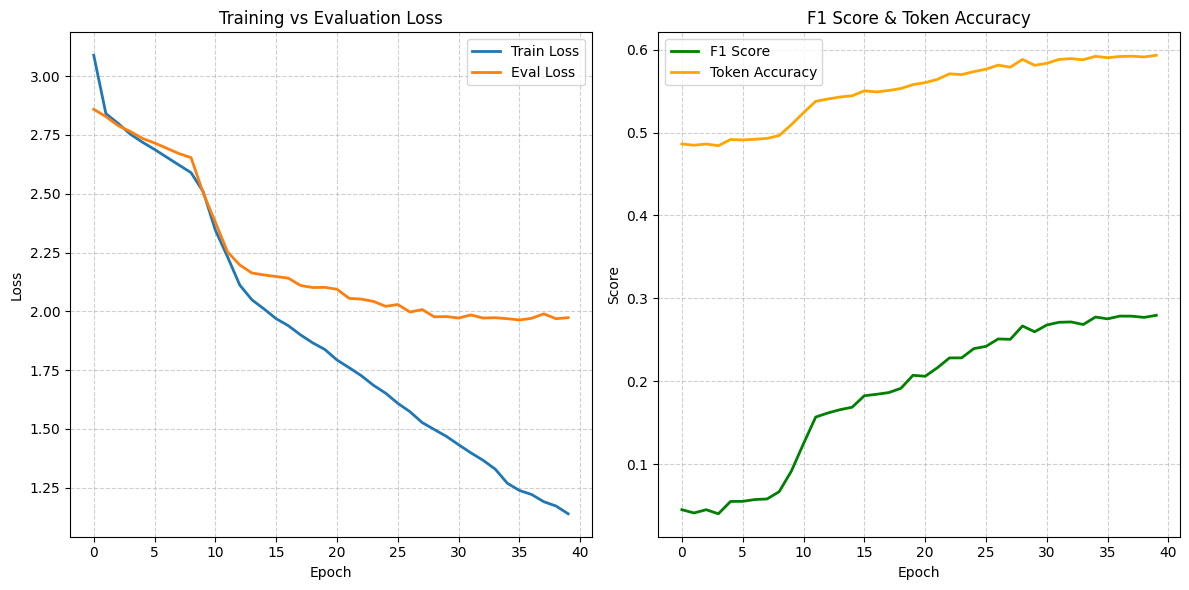

In [40]:
import matplotlib.pyplot as plt

# Giả sử bạn đã có:
# VQA_model_history = {
#     "train_loss": [...],
#     "eval_loss": [...],
#     "f1_score": [...],
#     "accuracy": [...]
# }

# --- Thiết lập figure ---
plt.figure(figsize=(12, 6))

# --- Biểu đồ Loss ---
plt.subplot(1, 2, 1)
plt.plot(VQA_model_history["train_loss"], label="Train Loss", linewidth=2)
plt.plot(VQA_model_history["eval_loss"], label="Eval Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# --- Biểu đồ F1 & Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(VQA_model_history["f1_score"], label="F1 Score", color="green", linewidth=2)
plt.plot(VQA_model_history["accuracy"], label="Token Accuracy", color="orange", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("F1 Score & Token Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [77]:
@torch.no_grad()
def top1accuracy_val(model, val_loader, device, pad_token_id=1):
    """
    Đánh giá độ chính xác Top-1 token-level của mô hình VQA trên tập validation.

    Args:
        model: mô hình VQA đã huấn luyện.
        val_loader: DataLoader chứa tập validation.
        device: 'cuda' hoặc 'cpu'.
        pad_token_id: chỉ số token <pad> trong từ điển.

    Returns:
        float: Top-1 token-level Accuracy (%)
    """
    model.eval()
    total_correct = 0
    total_tokens = 0

    for images, questions, answers in val_loader:
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        # Dự đoán chuỗi câu trả lời
        outputs = model(images, questions, answers[:, :-1])  # [B, seq_len-1, vocab_size]
        preds = torch.argmax(outputs, dim=-1)                # [B, seq_len-1]

        # Bỏ token <sos> và <pad>
        targets = answers[:, 1:]                             # [B, seq_len-1]
        mask = (targets != pad_token_id)

        correct = ((preds == targets) & mask).sum().item()
        total = mask.sum().item()

        total_correct += correct
        total_tokens += total

    acc = 100 * total_correct / total_tokens if total_tokens > 0 else 0
    print(f"✅ Top-1 Validation Accuracy: {acc:.2f}% ({total_correct}/{total_tokens})")
    return acc


In [78]:
val_acc = top1accuracy_val(VQA_model, eval_loader, device)
print(f"Validation Accuracy: {val_acc:.2f}%")


✅ Top-1 Validation Accuracy: 59.04% (3164/5359)
Validation Accuracy: 59.04%


In [73]:
def test_model(model, question, image_path, ground_truth, idx2word):
    """
    Kiểm tra mô hình VQA với một câu hỏi và một ảnh.

    Parameters:
    - model (torch.nn.Module): Mô hình đã huấn luyện.
    - question (str): Câu hỏi đầu vào.
    - image_path (str): Đường dẫn ảnh.
    - idx2word (dict): Từ điển ánh xạ chỉ mục → từ.

    Returns:
    - str: Câu trả lời dự đoán.
    """
    # Tiền xử lý ảnh
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension

    # Tiền xử lý câu hỏi
    question_tensor = text_to_tensor(question, vocab_questions, len_max_question).unsqueeze(0).to(device)  # Hàm mã hóa câu hỏi

    # Dự đoán câu trả lời
    model.eval()
    with torch.no_grad():
        output = model(image_tensor, question_tensor)

    # Chuyển tensor thành câu trả lời văn bản
    predicted_answer = tensor_to_text(output, idx2word)[0]  # Chỉ lấy câu đầu tiên

    # Hiển thị ảnh và kết quả
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Q: {question}\nPredicted answer: {predicted_answer}\nGround Truth: {ground_truth}", fontsize=12)
    plt.show()

    return predicted_answer

In [74]:
def test_random_samples(model, eval_dataframe, idx2word, vocab_questions, len_max_question, device):
    """Lấy ngẫu nhiên 15 mẫu để kiểm tra mô hình."""
    samples = eval_dataframe.sample(n=15)

    for _, row in samples.iterrows():
        question = row['question']
        image_path = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/' + row['image_id'] + '.png'
        ground_truth = row['answer']  # Changed 'response' to 'answer'

        predicted_answer = test_model(model, question, image_path, ground_truth, idx2word)

        # Hiển thị ảnh và kết quả
        # The test_model function already displays the image and results,
        # so we don't need to repeat it here.
        pass

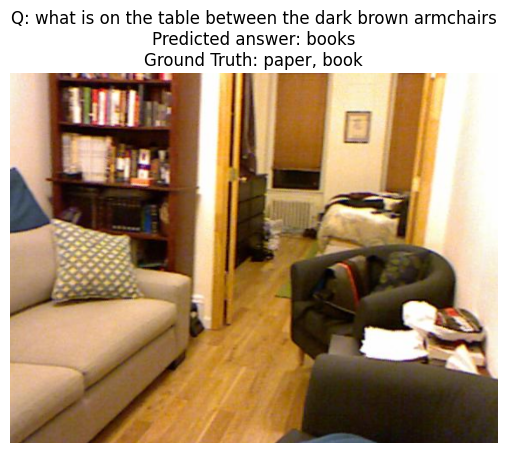

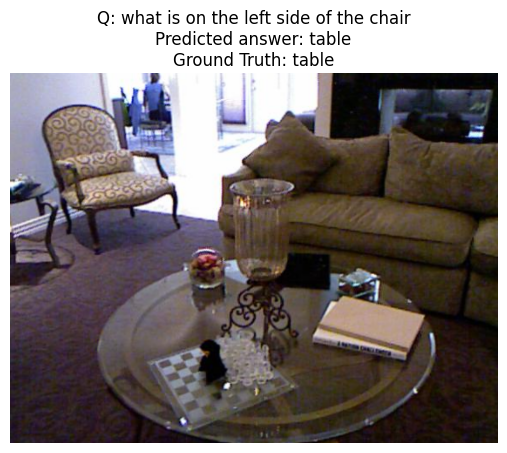

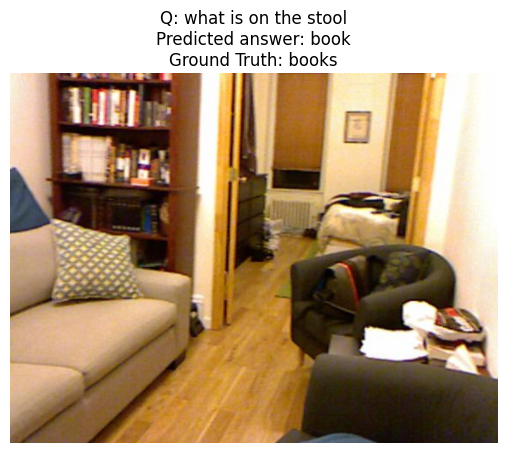

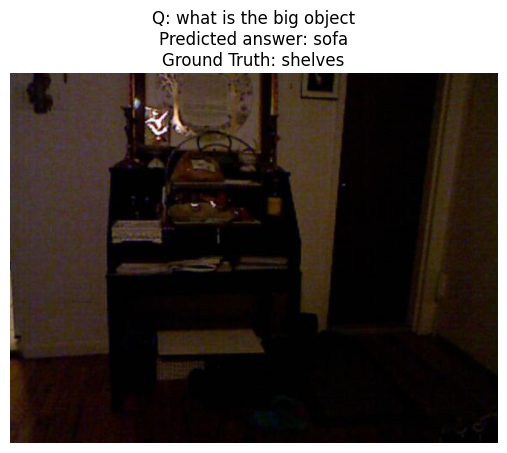

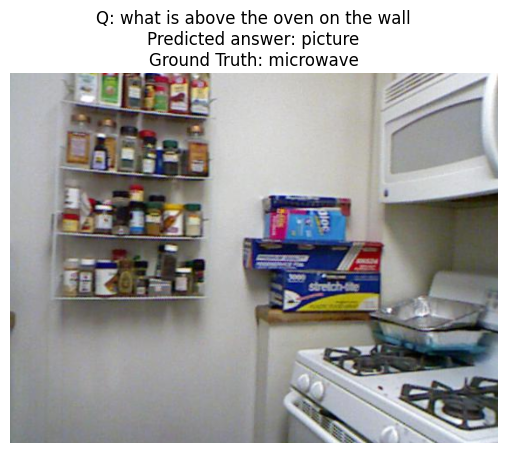

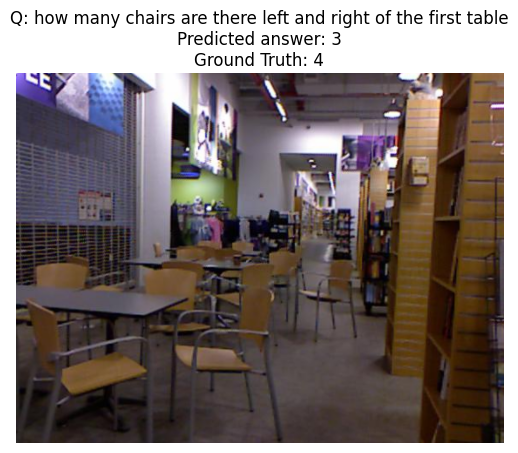

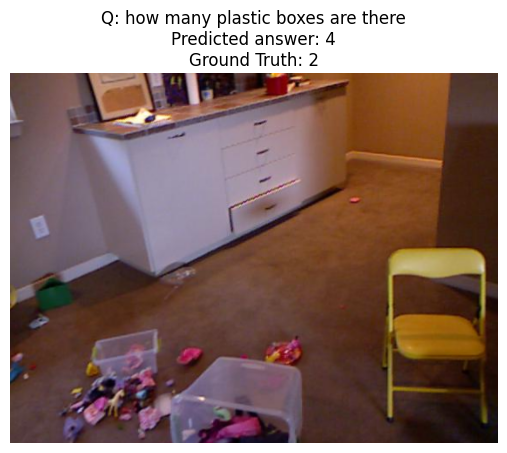

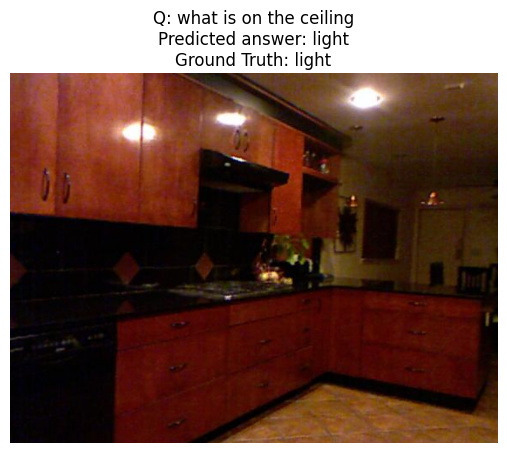

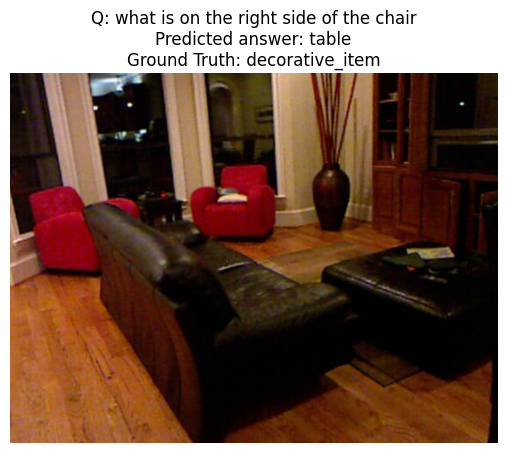

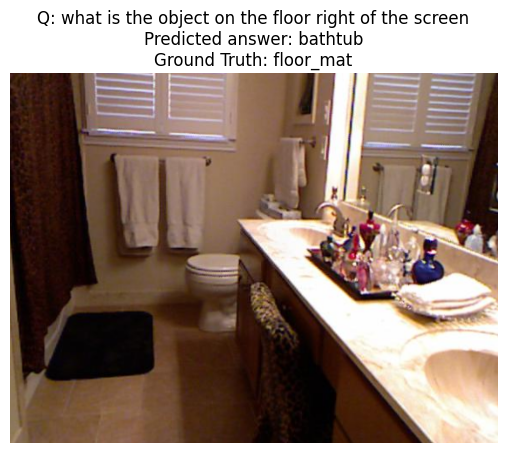

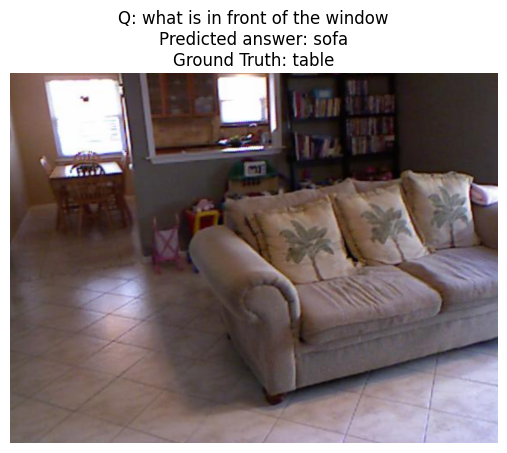

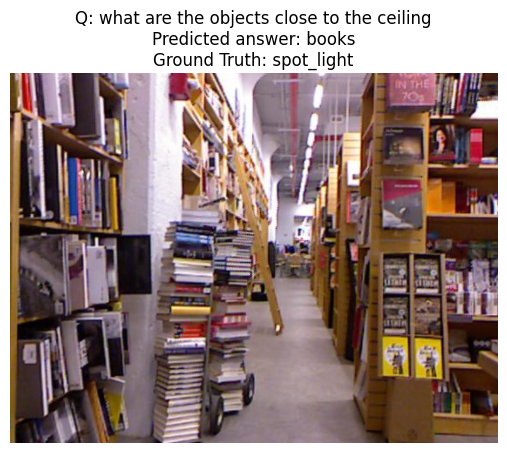

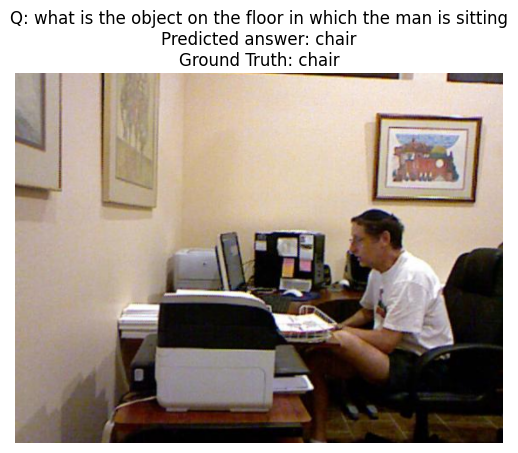

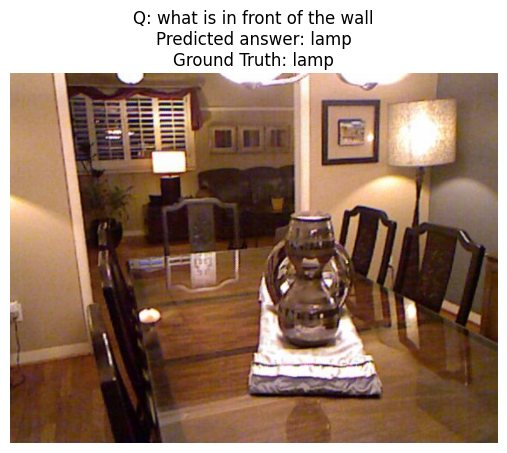

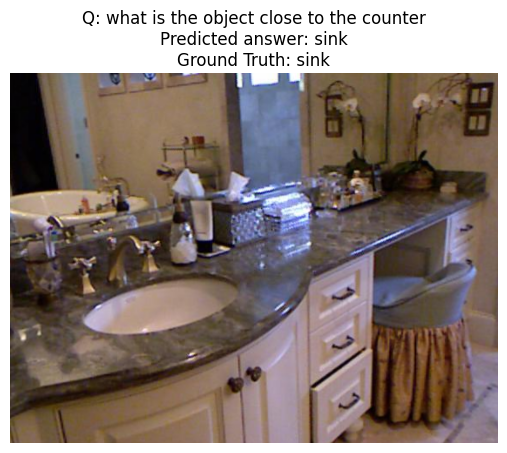

In [76]:
test_random_samples(VQA_model, eval_dataframe, idx2word_answers, vocab_questions, len_max_question, device)